### Kaggle Link
https://www.kaggle.com/c/digit-recognizer

### Data Introduction

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn import preprocessing

%matplotlib inline

### Loading and Pre-Processing Data

In [2]:
train_df = pd.read_csv("Data/mnist-train.csv")
valid_df = pd.read_csv("Data/mnist-test.csv")

X_train = train_df.drop(['label'], axis=1).values.astype('float32')
y_train = train_df['label'].values
X_valid = valid_df.values.astype('float32')

del train_df
del valid_df

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

img_rows = 28
img_cols = 28
n_targets = 10

input_shape = (img_rows, img_cols, 1)

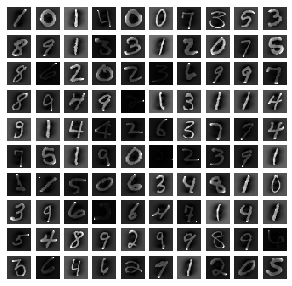

In [3]:
# The data that we are interested in is made of 28x28 images of digits, let's
# have a look at the first images, stored in X_train. For these
# images, we know which digit they represent: it is given by the correspondent y_train.
images_and_labels = list(zip(X_train, y_train))

f, axes = plt.subplots(10, 10, figsize=(5, 5))
for index, (image, label) in enumerate(images_and_labels[:100]):
    axes[int(index/10)][int(index%10)].imshow(image.reshape(img_rows, img_cols), cmap='gray', interpolation='nearest')
    axes[int(index/10)][int(index%10)].set_xticks(np.array([]))
    axes[int(index/10)][int(index%10)].set_yticks(np.array([]))

### Visualization

In [4]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

### Convolutional Neural Networks

In [5]:
import os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import optimizers

Using TensorFlow backend.


In [6]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)

In [7]:
# The y_train is not split into 10 distinct class labels, but rather 
# are represented as a single array with the class values
y_train = to_categorical(y_train)

#### Model Architecture

---

1. Basic Concepts:   
    * [2D Convolution](https://keras.io/layers/convolutional/#convolution2d)
    
    The main concept to implement a CNN. This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
    
    * [Max Pooling](https://keras.io/layers/pooling/#maxpooling2d)
    
    Reduces the size of the filter maps, by applying a max filter to non-overlapping subregions. A max pooling layer with pooling_size=2 will reduce the number total number of parameters in the filter map by a factor of 4.
    
    * [Dropout](https://keras.io/layers/core/#dropout)
    
   Consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
   
   * [Flatten](https://keras.io/layers/core/#flatten)
   
   Flattens the input. Does not affect the batch size.
   
   * [Dense](https://keras.io/layers/core/#dense)
   
   Just a regular densely-connected NN layer.
   
   * [Activation](https://keras.io/layers/core/#activation)
   
   Applies an activation function to an output.

2. Architecture:

    * Sequential Model
    * Convolutional Layer 
    * MaxPooling
    * Convolutional Layer 
    * MaxPooling
    * Dropout
    * Dense Layer

3. Obs:

     * [Epoch vs Batch Size vs Iterations](https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks)
     * [Optimizers](https://keras.io/optimizers/)
     * [Loss Functions](https://keras.io/losses/)

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(6, 6), activation='relu', input_shape=input_shape, padding='valid'))
model.add(Conv2D(64, kernel_size=(6, 6), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(n_targets, activation='softmax'))

In [9]:
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy',  metrics=['accuracy'])
hist = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=2, validation_split=0.33)

Train on 28139 samples, validate on 13861 samples
Epoch 1/10
207s - loss: 0.2949 - acc: 0.9147 - val_loss: 0.0860 - val_acc: 0.9739
Epoch 2/10
205s - loss: 0.1261 - acc: 0.9637 - val_loss: 0.0522 - val_acc: 0.9830
Epoch 3/10
202s - loss: 0.0977 - acc: 0.9724 - val_loss: 0.0449 - val_acc: 0.9868
Epoch 4/10
202s - loss: 0.0775 - acc: 0.9765 - val_loss: 0.0462 - val_acc: 0.9857
Epoch 5/10
204s - loss: 0.0648 - acc: 0.9802 - val_loss: 0.0385 - val_acc: 0.9884
Epoch 6/10
204s - loss: 0.0570 - acc: 0.9842 - val_loss: 0.0366 - val_acc: 0.9888
Epoch 7/10
201s - loss: 0.0556 - acc: 0.9832 - val_loss: 0.0368 - val_acc: 0.9887
Epoch 8/10
196s - loss: 0.0469 - acc: 0.9857 - val_loss: 0.0335 - val_acc: 0.9907
Epoch 9/10
191s - loss: 0.0405 - acc: 0.9872 - val_loss: 0.0348 - val_acc: 0.9896
Epoch 10/10
190s - loss: 0.0443 - acc: 0.9862 - val_loss: 0.0368 - val_acc: 0.9888


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


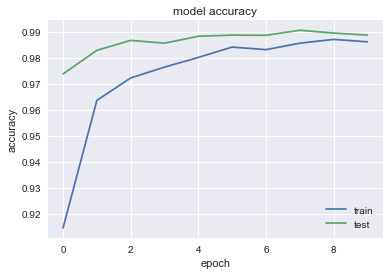

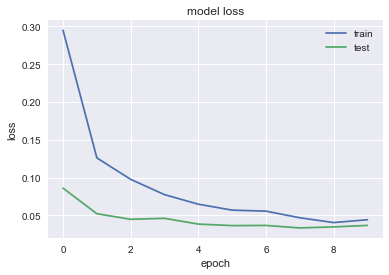

In [10]:
plot_history(hist)

In [11]:
pred = model.predict_classes(X_valid)

np.savetxt('mnist-output.csv', np.c_[range(1,len(pred)+1),pred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')

28000/28000 [==============================] - 66s    
